# Labolatorium 3: Analiza Danych w języku R

Jakub Fabia

## Importowanie bibliotek
Importuję niezbędną bibliotekę - `tidyverse` w której skład m.in. wchodzą:
- `ggplot2` wizualizacja danych,
- `dplyr` manipulacja danymi.

Ustawiam także odpowiedni katalog bieżący (do funkcji `read_csv`)

In [1]:
library("tidyverse")
setwd("~/app/Lab1/Assignment")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Funkcje obliczeniowe

Funkcja `generalized_dot` oblicza uogólniony iloczyn skalarny dwóch wektorów `x` i `y` oraz macierzy `A`. 

Funkcja `matrix_vector_product` oblicza iloczyn wektora `x` oraz macierzy `A`.

In [2]:
generalized_dot <- function(x, A, y) {
  return(t(x) %*% A %*% y)
}

matrix_vector_product <- function(A, x) {
  return(A %*% x)
}

## Funkcje zbierające, agregujące i wizualizujące dane
Funkcja `benchmark_functions` przeprowadza testy wydajnościowe dla funkcji `generalized_dot` oraz `matrix_vector_product`. <br>
Dla różnych rozmiarów macierzy i wektorów (`sizes`) oraz określonej liczby prób (`num_trials`), funkcja generuje losowe macierze `A` oraz wektory `x` i `y`. <br>
Następnie mierzy czas wykonania obu funkcji dla tych danych. Wyniki są zapisywane do dataframe `tibble`. <br>
Pierwsza próba dla każdego rozmiaru jest pomijana, ponieważ mierzy także czas kompilacji.

In [3]:
benchmark_functions <- function(sizes, num_trials) {
  results <- tibble(size = integer(), sample = integer(), time_dot = double(), time_matrix_vector = double())
  
  for (n in sizes) {
    for (i in 0:num_trials) {
      A <- matrix(runif(n * n), nrow = n, ncol = n)
      x <- runif(n)
      y <- runif(n)
      
      time_dot <- system.time(generalized_dot(x, A, y))[3]
      time_matrix_vector <- system.time(matrix_vector_product(A, x))[3]

      if (i != 0) {
        results <- bind_rows(results, tibble(size = n, sample = i, time_dot = time_dot, time_matrix_vector = time_matrix_vector))
      }
    }
  }
  return(results)
}

Funkcja `summarize_benchmark` przyjmuje dataframe z odpowiednio nazwanymi pomiarami. Dla każdego rozmiaru wektorów oblicza średnią oraz odchylenie standardowe.

In [4]:
summarize_benchmark <- function(df) {
  df %>% 
    group_by(size) %>% 
    summarise(
      time_dot_mean = mean(time_dot),
      time_dot_sd = sd(time_dot),
      time_matrix_vector_mean = mean(time_matrix_vector),
      time_matrix_vector_sd = sd(time_matrix_vector)
    )
}

Funkcja `plot_benchmark_results` wykonuje odpowiednie wykresy z dataframe.

In [5]:
plot_benchmark_results <- function(plot_df) {    
    p1 <- ggplot(plot_df, aes(x = size, y = time_dot_mean)) +
        geom_point() +
        geom_errorbar(aes(ymin = time_dot_mean - time_dot_sd, ymax = time_dot_mean + time_dot_sd), width = 50) +
        ggtitle("Uogólniony Iloczyn Skalarny") +
        xlab("Rozmiar Wektorów") +
        ylab("Czas [s]")
    p2 <- ggplot(plot_df, aes(x = size, y = time_matrix_vector_mean)) +
        geom_point() +
        geom_errorbar(aes(ymin = time_matrix_vector_mean - time_matrix_vector_sd, ymax = time_matrix_vector_mean + time_matrix_vector_sd), width = 50) +
        ggtitle("Iloczyn Wektora i Macierzy") + 
        xlab("Rozmiar Wektorów") +
        ylab("Czas [s]")
    return(list(p1, p2))
}

Dla porównania importuje dane zebrane z analogicznych funkcji napisanych w języku **Julia** (Dane z labolatorium 1).

In [6]:
julia_benchmark_results <- read_csv("pomiary.csv")

Rows: 230 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): size, sample, time_dot, time_matrix_vector

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Tworzenie danych

In [7]:
sizes <- seq(800, 3000, by = 100)
num_trials <- 10
benchmark_results <- benchmark_functions(sizes, num_trials)

## Analiza danych

In [26]:
summarized_benchmarks <- summarize_benchmark(benchmark_results)
summarized_julia_benchmarks <- summarize_benchmark(julia_benchmark_results)

In [25]:
benchmark_results %>% filter(size == 2800)

size,sample,time_dot,time_matrix_vector
<dbl>,<int>,<dbl>,<dbl>
2800,1,0.009,0.008
2800,2,0.009,0.012
2800,3,0.008,0.014
2800,4,0.009,0.008
2800,5,0.008,0.010
2800,7,0.009,0.016
2800,8,0.008,0.008
2800,9,0.008,0.012
2800,10,0.008,0.008


Usunąłem wartość znacznie odstającą.

In [24]:
benchmark_results <- benchmark_results %>% filter(!(size == 2800 & time_matrix_vector > 0.040))

### R

In [9]:
print(benchmark_results)

# A tibble: 230 × 4
    size sample time_dot time_matrix_vector
   <dbl>  <int>    <dbl>              <dbl>
 1   800      1  0.00300            0.00200
 2   800      2  0.00700            0.00100
 3   800      3  0.00100            0.00700
 4   800      4  0.00100            0      
 5   800      5  0.00100            0.00100
 6   800      6  0.00100            0.00100
 7   800      7  0.0160             0.0220 
 8   800      8  0.0220             0.00100
 9   800      9  0.00800            0.00100
10   800     10  0.00100            0.00100
# ℹ 220 more rows


In [21]:
print(summarized_benchmarks)

# A tibble: 23 × 5
    size time_dot_mean time_dot_sd time_matrix_vector_mean time_matrix_vector_sd
   <dbl>         <dbl>       <dbl>                   <dbl>                 <dbl>
 1   800       0.00610    0.00742                  0.00370              0.00672 
 2   900       0.00130    0.000483                 0.00160              0.00190 
 3  1000       0.00360    0.00572                  0.00430              0.00904 
 4  1100       0.00420    0.00649                  0.00270              0.00469 
 5  1200       0.00160    0.000516                 0.00190              0.00185 
 6  1300       0.00480    0.00629                  0.00250              0.00212 
 7  1400       0.00700    0.00822                  0.00540              0.00576 
 8  1500       0.00440    0.00433                  0.00450              0.00657 
 9  1600       0.00290    0.000316                 0.00250              0.000527
10  1700       0.00450    0.00440                  0.00500              0.00573 
# ℹ 13 mo

### Julia

In [20]:
print(julia_benchmark_results)

# A tibble: 230 × 4
    size sample time_dot time_matrix_vector
   <dbl>  <dbl>    <dbl>              <dbl>
 1   800      1 0.000322          0.000104 
 2   800      2 0.000256          0.000279 
 3   800      3 0.000303          0.000218 
 4   800      4 0.000214          0.000102 
 5   800      5 0.000273          0.000100 
 6   800      6 0.000309          0.000103 
 7   800      7 0.000209          0.0000985
 8   800      8 0.000226          0.0000994
 9   800      9 0.000270          0.000103 
10   800     10 0.000235          0.000102 
# ℹ 220 more rows


In [12]:
print(summarized_julia_benchmarks)

# A tibble: 23 × 5
    size time_dot_mean time_dot_sd time_matrix_vector_mean time_matrix_vector_sd
   <dbl>         <dbl>       <dbl>                   <dbl>                 <dbl>
 1   800      0.000262   0.0000408                0.000131            0.0000635 
 2   900      0.000375   0.0000749                0.000131            0.00000980
 3  1000      0.000458   0.0000620                0.000168            0.0000129 
 4  1100      0.000571   0.0000494                0.000191            0.0000148 
 5  1200      0.000753   0.0000866                0.000272            0.0000562 
 6  1300      0.000827   0.0000894                0.000293            0.0000483 
 7  1400      0.00101    0.0000733                0.000385            0.0000668 
 8  1500      0.00115    0.000104                 0.000463            0.0000565 
 9  1600      0.00128    0.000115                 0.000534            0.0000713 
10  1700      0.00139    0.000141                 0.000631            0.0000537 
# ℹ 13 mo

## Wykresy

### R

[[1]]

[[2]]


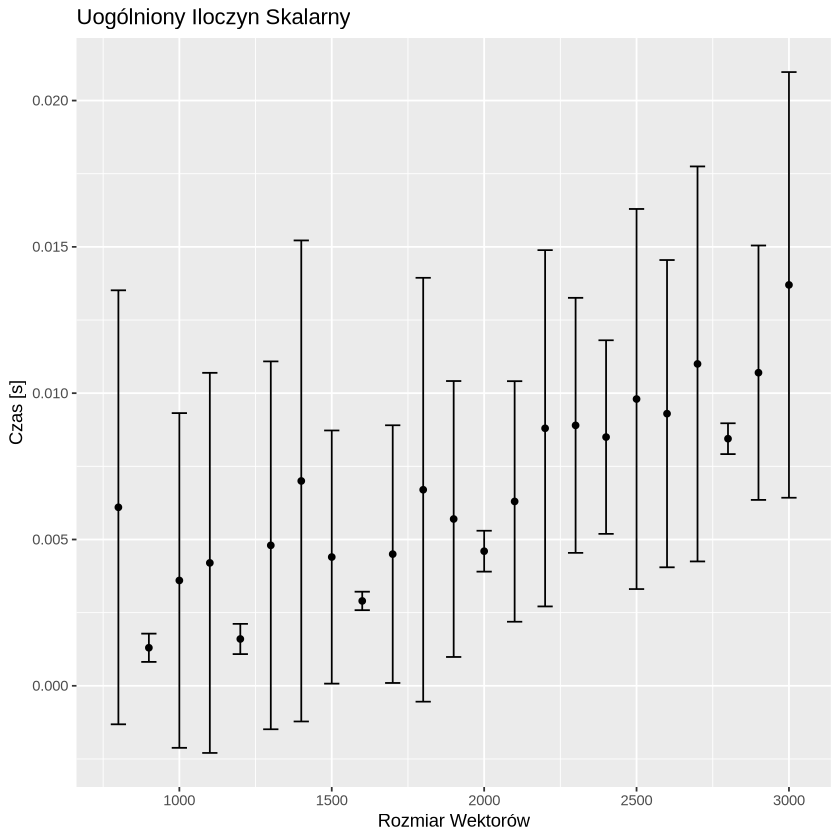

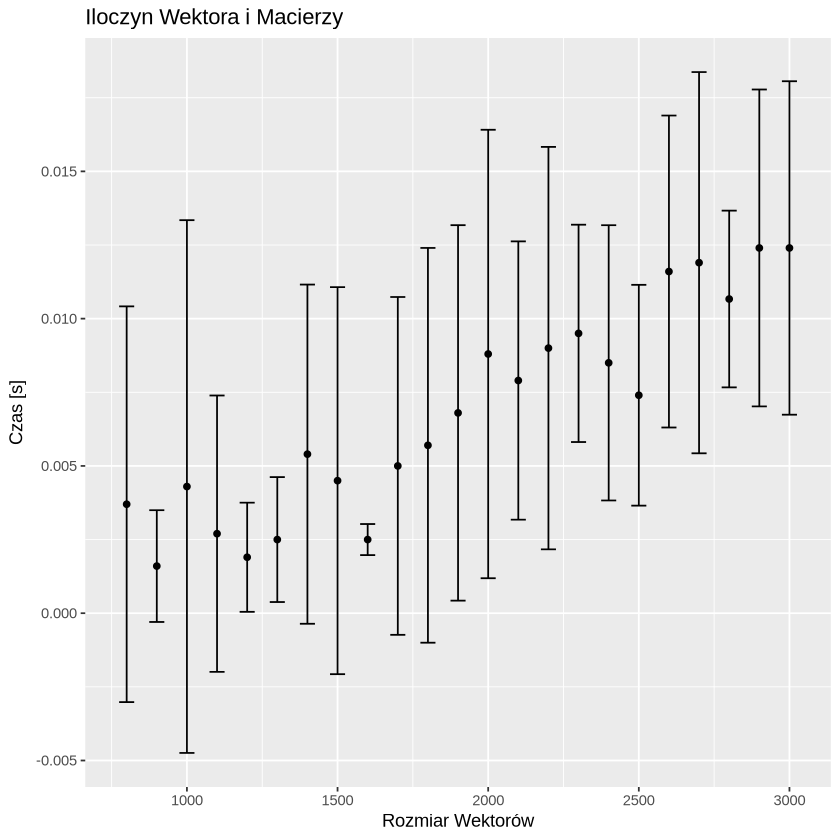

In [27]:
print(plot_benchmark_results(summarized_benchmarks))

### Julia

[[1]]

[[2]]


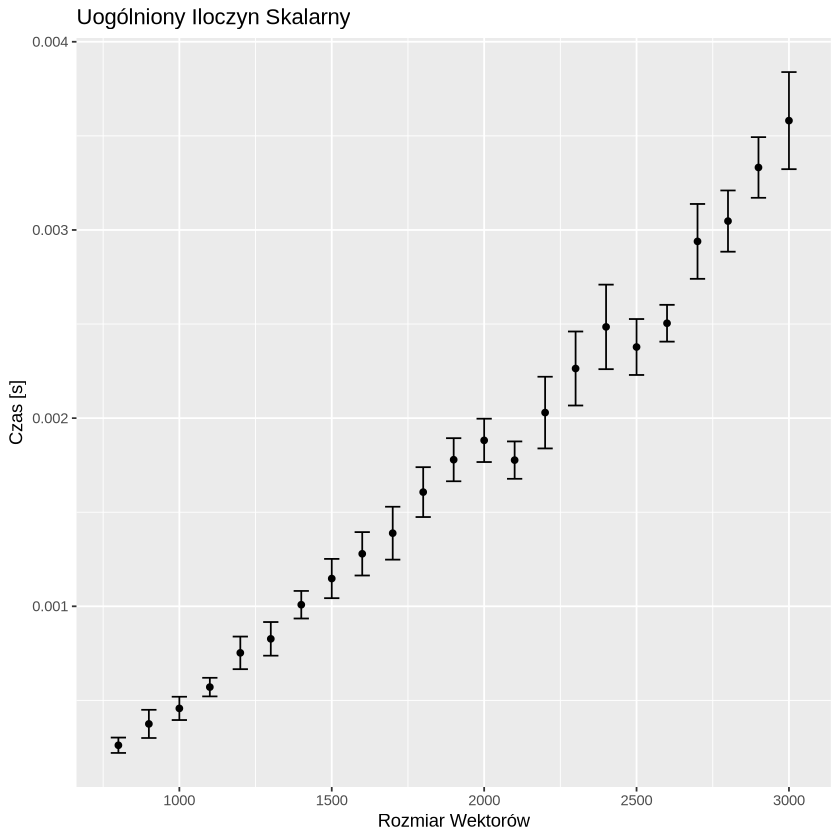

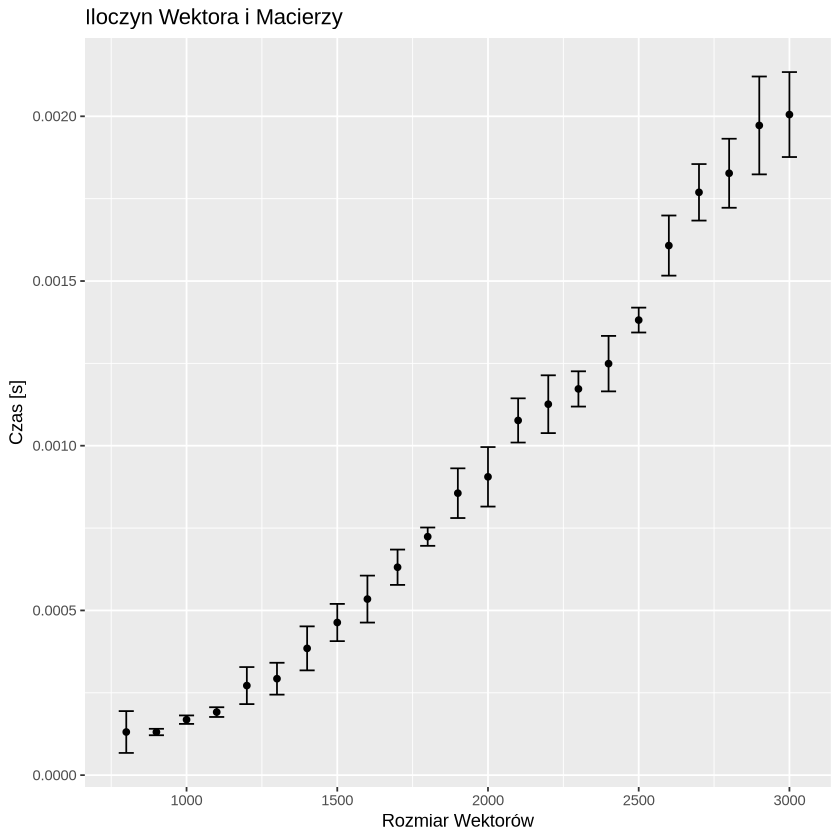

In [14]:
print(plot_benchmark_results(summarized_julia_benchmarks))